In [1]:
import time
import copy
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import Model
from keras.layers import Input, Dense, Dropout, Lambda, Concatenate, Multiply, Reshape, ActivityRegularization
from keras import losses, optimizers
from keras.callbacks import EarlyStopping
import keras.backend as K

from carl.learning.calibration import HistogramCalibrator, IsotonicCalibrator

from awkde import GaussianKDE

/Users/johannbrehmer/anaconda3/envs/higgs_inference/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/Users/johannbrehmer/anaconda3/envs/higgs_inference/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


# Translation between s and r

In [2]:
def s(r):
    return 1./(1. + r)

def r(s):
    return (1.-s)/s

# Data

In [3]:
# Benchmark
theta1 = 708
theta = 9

# Data
data_dir = '../data'

X_train = np.load(data_dir + '/unweighted_events/X_train_point_by_point_9.npy')
y_train = np.load(data_dir + '/unweighted_events/y_train_point_by_point_9.npy')
r_train = np.load(data_dir + '/unweighted_events/r_train_point_by_point_9.npy')

X_calibration = np.load(data_dir + '/unweighted_events/X_calibration.npy')
weights_calibration = np.load(
    data_dir + '/unweighted_events/weights_calibration.npy')

X_test = np.load(data_dir + '/unweighted_events/X_test.npy')
r_test = np.load(data_dir + '/unweighted_events/r_test.npy')[9]
    
# Scale data
scaler = StandardScaler()
scaler.fit(np.array(X_train, dtype=np.float64))
X_train_transformed = scaler.transform(X_train)
X_calibration_transformed = scaler.transform(X_calibration)
X_test_transformed = scaler.transform(X_test)

# keras requires training data with the same output as the NN
log_r_gradients_train = np.zeros((r_train.shape[0], 43))
log_r_gradients_train[:,0] = np.log(r_train)
y_gradients_train = np.zeros((r_train.shape[0], 43))
y_gradients_train[:,0] = y_train

# Finally, s points for the calibration curves
s_eval = np.linspace(0., 1., 200).reshape((-1,1))

In [4]:
X_indices = [0,1,2,3,39,40,41] # j1 momentum + delta eta, delta phi, mjj
X_small = X_train_transformed[::,X_indices]
cov_X = np.cov(X_small, rowvar=False)

# Train regression

In [5]:
n_features = 42

def stack_layer(layers):
    def f(x):
        for k in range(len(layers)):
            x = layers[k](x)
        return x

    return f

def hidden_layers(n,
                  hidden_layer_size=100,
                  activation='tanh',
                  dropout_prob=0.0):
    r = []
    for k in range(n):
        if dropout_prob > 0.:
            s = stack_layer([
                Dropout(dropout_prob),
                Dense(hidden_layer_size, activation=activation)
            ])
        else:
            s = stack_layer([Dense(hidden_layer_size, activation=activation)])
        r.append(s)
    return stack_layer(r)

def loss_function_regression(y_true, y_pred):
    return losses.mean_squared_error(y_true[:,0], y_pred[:,0])

def make_regressor(n_hidden_layers=3,
                   hidden_layer_size=100,
                   activation='tanh',
                   dropout_prob=0.0):

    # Inputs
    input_layer = Input(shape=(n_features,))

    # Network
    hidden_layer = Dense(hidden_layer_size, activation=activation)(input_layer)
    if n_hidden_layers > 1:
        hidden_layer_ = hidden_layers(n_hidden_layers - 1,
                                      hidden_layer_size=hidden_layer_size,
                                      activation=activation,
                                      dropout_prob=dropout_prob)
        hidden_layer = hidden_layer_(hidden_layer)
    log_r_hat_layer = Dense(1, activation='linear')(hidden_layer)
    s_hat_layer = Lambda(lambda x : 1. / 1. + x)(log_r_hat_layer)

    # gradients with respect to x
    gradient_layer = Lambda(lambda x: K.gradients(x[0], x[1])[0],
                            output_shape=(n_features,))([s_hat_layer, input_layer])

    # Combine outputs
    output_layer = Concatenate()([log_r_hat_layer, gradient_layer])
    model = Model(inputs=[input_layer], outputs=[output_layer])

    # Compile model
    model.compile(loss=loss_function_regression,
                  optimizer=optimizers.Adam(clipnorm=1.))

    return model

In [6]:
# Train score regression
regr = KerasRegressor(lambda: make_regressor(n_hidden_layers=2),
                     epochs=20, verbose=1, validation_split=0.2,
                     callbacks=[EarlyStopping(verbose=1, patience=3)])

regr.fit(X_train_transformed, log_r_gradients_train)

Train on 80000 samples, validate on 20000 samples
Epoch 1/20
80000/80000 [==============================] - 4s 54us/step - loss: 0.1474 - val_loss: 0.1955
Epoch 2/20
80000/80000 [==============================] - 4s 52us/step - loss: 0.0658 - val_loss: 0.1220
Epoch 3/20
80000/80000 [==============================] - 4s 52us/step - loss: 0.0475 - val_loss: 0.1045
Epoch 4/20
80000/80000 [==============================] - 4s 55us/step - loss: 0.0351 - val_loss: 0.0793
Epoch 5/20
80000/80000 [==============================] - 4s 50us/step - loss: 0.0289 - val_loss: 0.0678
Epoch 6/20
80000/80000 [==============================] - 4s 46us/step - loss: 0.0251 - val_loss: 0.0610
Epoch 7/20
80000/80000 [==============================] - 4s 47us/step - loss: 0.0218 - val_loss: 0.0634
Epoch 8/20
80000/80000 [==============================] - 3s 43us/step - loss: 0.0200 - val_loss: 0.0486
Epoch 9/20
80000/80000 [==============================] - 3s 43us/step - loss: 0.0187 - val_loss: 0.0461
Epoch

In [7]:
# Evaluate on calibration sample
calibration_predictions = regr.predict(X_calibration_transformed)
log_r_hat_regr_calibration = calibration_predictions[:,0]
s_hat_regr_calibration = s(np.exp(log_r_hat_regr_calibration))
gradients_regr_calibration = calibration_predictions[:,1:]

s_hat_regr_calibration_carlinput = np.hstack((s_hat_regr_calibration,s_hat_regr_calibration))
y_regr_calibration_carlinput = np.hstack((np.zeros_like(s_hat_regr_calibration), np.ones_like(s_hat_regr_calibration)))
w_regr_calibration_carlinput = np.hstack((weights_calibration[theta,::], weights_calibration[theta1,::]))

# Evaluate on test sample
r_hat_regr_test = np.exp(regr.predict(X_test_transformed)[:,0])
s_hat_regr_test = s(r_hat_regr_test)

48238/48238 [==============================] - 1s 13us/step


In [8]:
#Calculate KDE bandwidths
grad_cov_grad = np.diag( gradients_regr_calibration[:,X_indices].dot(
    cov_X.dot(gradients_regr_calibration[:,X_indices].T)))

#mean_bw_nom = 1.5*1.5/11.4 * 1.5/2.37 * 1.5/1.8
#mean_bw_den = 1.1*1.1/5.85 * 1.09/1.27 * 1.09 / 1.2
#bandwidths = np.sqrt(grad_cov_grad)
#bandwidths = np.clip(bandwidths, np.mean(bandwidths) / 100., np.mean(bandwidths) * 100.)
#bandwidths_nom = mean_bw_nom / np.mean(bandwidths) * bandwidths
#bandwidths_nom = np.clip(bandwidths_nom, 0.1,10.)
#bandwidths_den = mean_bw_den / np.mean(bandwidths) * bandwidths
#bandwidths_den = np.clip(bandwidths_den, 0.1,10.)

bandwidths_regr = np.sqrt(grad_cov_grad)
bandwidths_regr = np.clip(bandwidths_regr, 0., np.mean(bandwidths_regr) * 10.)
bandwidths_regr /= np.mean(bandwidths_regr)
bandwidths_regr = np.clip(bandwidths_regr, 0.1,10.)
print(np.min(bandwidths_regr), np.mean(bandwidths_regr), np.max(bandwidths_regr))

0.1 0.9995625030913593 10.0


# Train carl

In [9]:
def loss_function_carl(y_true, y_pred):
    return losses.binary_crossentropy(y_true[:,0], y_pred[:,0])

def make_classifier(n_hidden_layers=3,
                   hidden_layer_size=100,
                   activation='tanh',
                   dropout_prob=0.0):

    # Inputs
    input_layer = Input(shape=(n_features,))

    # Network
    hidden_layer = Dense(hidden_layer_size, activation=activation)(input_layer)
    if n_hidden_layers > 1:
        hidden_layer_ = hidden_layers(n_hidden_layers - 1,
                                      hidden_layer_size=hidden_layer_size,
                                      activation=activation,
                                      dropout_prob=dropout_prob)
        hidden_layer = hidden_layer_(hidden_layer)
        
    log_r_hat_layer = Dense(1, activation='linear')(hidden_layer)
    r_hat_layer = Lambda(lambda x: K.exp(x))(log_r_hat_layer)
    s_hat_layer = Lambda(lambda x: 1./(1. + x))(r_hat_layer)

    # gradients with respect to x
    gradient_layer = Lambda(lambda x: K.gradients(x[0], x[1])[0],
                            output_shape=(n_features,))([s_hat_layer, input_layer])

    # Combine outputs
    output_layer = Concatenate()([s_hat_layer, gradient_layer])
    model = Model(inputs=[input_layer], outputs=[output_layer])

    # Compile model
    model.compile(loss=loss_function_carl,
                  optimizer=optimizers.Adam(clipnorm=1.))

    return model

In [10]:
# Train score regression
clf = KerasRegressor(lambda: make_classifier(n_hidden_layers=2),
                     epochs=20, verbose=1, validation_split=0.2,
                     callbacks=[EarlyStopping(verbose=1, patience=3)])

clf.fit(X_train_transformed, y_gradients_train)

Train on 80000 samples, validate on 20000 samples
Epoch 1/20
80000/80000 [==============================] - 5s 63us/step - loss: 0.6402 - val_loss: 0.9155
Epoch 2/20
80000/80000 [==============================] - 5s 58us/step - loss: 0.6318 - val_loss: 0.8751
Epoch 3/20
80000/80000 [==============================] - 5s 59us/step - loss: 0.6295 - val_loss: 0.9700
Epoch 4/20
80000/80000 [==============================] - 5s 65us/step - loss: 0.6273 - val_loss: 0.9642
Epoch 5/20
80000/80000 [==============================] - 5s 60us/step - loss: 0.6259 - val_loss: 0.9558
Epoch 00005: early stopping


In [11]:
# Evaluate on calibration sample
calibration_predictions = clf.predict(X_calibration_transformed)
s_hat_carl_calibration = calibration_predictions[:,0]
gradients_carl_calibration = calibration_predictions[:,1:]

s_hat_carl_calibration_carlinput = np.hstack((s_hat_carl_calibration,s_hat_carl_calibration))
y_carl_calibration_carlinput = np.hstack((np.zeros_like(s_hat_carl_calibration),
                                          np.ones_like(s_hat_carl_calibration)))
w_carl_calibration_carlinput = np.hstack((weights_calibration[theta,::], weights_calibration[theta1,::]))

# Evaluate on test sample
s_hat_carl_test = clf.predict(X_test_transformed)[:,0]
r_hat_carl_test = r(s_hat_carl_test)

48238/48238 [==============================] - 1s 15us/step


In [12]:
#Calculate KDE bandwidths
grad_cov_grad = np.diag( gradients_carl_calibration[:,X_indices].dot(
    cov_X.dot(gradients_carl_calibration[:,X_indices].T)))

#mean_bw_nom = 1.5*1.5/11.4 * 1.5/2.37 * 1.5/1.8
#mean_bw_den = 1.1*1.1/5.85 * 1.09/1.27 * 1.09 / 1.2
#bandwidths = np.sqrt(grad_cov_grad)
#bandwidths = np.clip(bandwidths, np.mean(bandwidths) / 100., np.mean(bandwidths) * 100.)
#bandwidths_nom = mean_bw_nom / np.mean(bandwidths) * bandwidths
#bandwidths_nom = np.clip(bandwidths_nom, 0.1,10.)
#bandwidths_den = mean_bw_den / np.mean(bandwidths) * bandwidths
#bandwidths_den = np.clip(bandwidths_den, 0.1,10.)

bandwidths_carl = np.sqrt(grad_cov_grad)
bandwidths_carl = np.clip(bandwidths_carl, 0., np.mean(bandwidths_carl) * 10.)
bandwidths_carl /= np.mean(bandwidths_carl)
bandwidths_carl = np.clip(bandwidths_carl, 0.1,10.)
print(np.min(bandwidths_carl), np.mean(bandwidths_carl), np.max(bandwidths_carl))

0.1 1.0001873133716204 5.792559944203767


# Calibration method list

In [33]:
# list of tuples (label1, label2, tool, mode, settings)
# label is used in tables and plots
# tool can be 'carl' for the built-in calibration methods and 'kde'
#   for the adaptive KDE techniques (including the gradient one)
# mode can be 'histogram', 'isotonic', ... for tool='carl', and
#   'fixed', 'adaptive', 'grad' for tool='kde'
# settings is a dict with settings passed to the Calibrator or GaussianKDE objects

calibrations = [] 

def _add(*args):
    calibrations.append(args)
    
# Uncalibrated
_add('No calibration', '', 'none', None, None)

# carl histogram calibration
_add('Histogram', '30 equidistant bins', 'carl', 'histo', {'bins':30, 'independent_binning':False, 'variable_width':False})
_add('', '50 equidistant bins', 'carl', 'histo', {'bins':50, 'independent_binning':False, 'variable_width':False})
_add('', '100 equidistant bins', 'carl', 'histo', {'bins':100, 'independent_binning':False, 'variable_width':False})
_add('', '200 equidistant bins', 'carl', 'histo', {'bins':200, 'independent_binning':False, 'variable_width':False})
_add('', '30 variable bins', 'carl', 'histo', {'bins':30, 'independent_binning':False, 'variable_width':True})
_add('', '50 variable bins', 'carl', 'histo', {'bins':50, 'independent_binning':False, 'variable_width':True})
_add('', '100 variable bins', 'carl', 'histo', {'bins':100, 'independent_binning':False, 'variable_width':True})
_add('', '200 variable bins', 'carl', 'histo', {'bins':200, 'independent_binning':False, 'variable_width':True})

# other carl methods
_add('Isotonic', '', 'carl', 'isotonic', {})

# fixed KDE
_add('KDE', 'fixed bandwidth', 'kde', 'fixed', {})

# adaptive KDE
_add('', r'adaptive ($\alpha=0.25$)', 'kde', 'adaptive', {'alpha':0.25})
_add('', r'adaptive ($\alpha=0.5$)', 'kde', 'adaptive', {'alpha':0.5})
_add('', r'adaptive ($\alpha=0.75$)', 'kde', 'adaptive', {'alpha':0.75})
_add('', r'adaptive ($\alpha=1.$)', 'kde', 'adaptive', {'alpha':1.})

# grad-adaptive KDE
_add('KDE', r'gradient-adaptive ($\beta=0.2$)', 'kde', 'grad', {'factor':0.2})
_add('', r'gradient-adaptive ($\beta=0.5$)', 'kde', 'grad', {'factor':0.5})
_add('', r'gradient-adaptive ($\beta=1$)', 'kde', 'grad', {'factor':1.})
_add('', r'gradient-adaptive ($\beta=2$)', 'kde', 'grad', {'factor':2.})

plot_labels = []
last_label1 = ''
for cal in calibrations:
    label2_string = '' if cal[1] == '' else ', ' + cal[1]
    if cal[0] == '':
        plot_labels.append(last_label1 + label2_string)
    else:
        plot_labels.append(cal[0] + label2_string)
        last_label1 = cal[0]


# Calibration routines

In [14]:
def calibrate_none(use_regression=False):
    
    # Optimal calibration curve
    r_hat_eval = r(s_eval)
    
    # Test sample
    if use_regression:
        r_hat_test = r_hat_regr_test
    else:
        r_hat_test = r_hat_carl_test
    
    # Return results
    return(r_hat_eval, r_hat_test)

In [15]:
def calibrate_carl(mode, settings, use_regression=False):
    
    # Fit carl Calibrator object
    if mode in ['histogram', 'histo']:
        calibrator = HistogramCalibrator(**settings)
    elif mode == 'isotonic':
        calibrator = IsotonicCalibrator(**settings)
    else:
        raise ValueError('Unknown mode "' + mode + '"')
    
    if use_regression:
        calibrator.fit(s_hat_regr_calibration_carlinput, y_regr_calibration_carlinput,
                       sample_weight=w_regr_calibration_carlinput)
    else:
        calibrator.fit(s_hat_carl_calibration_carlinput, y_carl_calibration_carlinput,
                       sample_weight=w_carl_calibration_carlinput)

    # Calibration curve
    s_hat_calibrated_eval = calibrator.predict(s_eval.reshape((-1,)))
    r_hat_calibrated_eval = r(s_hat_calibrated_eval)
    
    # Test sample
    if use_regression:
        s_hat_calibrated_test = calibrator.predict(s_hat_regr_test.reshape((-1,)))
    else:
        s_hat_calibrated_test = calibrator.predict(s_hat_carl_test.reshape((-1,)))
    r_hat_calibrated_test = r(s_hat_calibrated_test)
    
    # Return results
    return(r_hat_calibrated_eval, r_hat_calibrated_test)

In [16]:
def calibrate_kde(mode, settings, use_regression=False):
    
    # Settings
    settings_ = copy.deepcopy(settings)
    bandwidth_ = None
    
    if mode == 'fixed':
        settings_ = {'alpha':None}
        
    elif mode == 'adaptive':
        pass
    
    elif mode == 'grad':
        factor = settings_.pop('factor', 1.)
        bandwidth_ = factor * (bandwidths_regr if use_regression else bandwidths_carl)
        print(bandwidth_)
        
    else:
        raise ValueError(mode)
    
    pdf_nom = GaussianKDE(**settings_)
    pdf_den = GaussianKDE(**settings_)

    # Fit
    if use_regression:
        pdf_nom.fit(s_hat_regr_calibration.reshape((-1,1)),
                    weights=weights_calibration[theta,::],
                    bandwidth=bandwidth_)
        pdf_den.fit(s_hat_regr_calibration.reshape((-1,1)),
                    weights=weights_calibration[theta1,::],
                    bandwidth=bandwidth_)
    else:
        pdf_nom.fit(s_hat_carl_calibration.reshape((-1,1)),
                    weights=weights_calibration[theta,::],
                    bandwidth=bandwidth_)
        pdf_den.fit(s_hat_carl_calibration.reshape((-1,1)),
                    weights=weights_calibration[theta1,::],
                    bandwidth=bandwidth_)
        
    # Extract bandwidths (for debugging purposes)
    if mode in ['adaptive', 'grad']:
        actual_bandwidths_nom = 1. / pdf_nom._inv_loc_bw
        actual_bandwidths_den = 1. / pdf_den._inv_loc_bw
    else:
        actual_bandwidths_nom = actual_bandwidths_den = np.ones_like(s_hat_carl_calibration)
    
    # Calibration curve
    p_hat_nom_eval = pdf_nom.predict(s_eval)
    p_hat_den_eval = pdf_den.predict(s_eval)
    r_hat_calibrated_eval = p_hat_nom_eval / p_hat_den_eval
    r_hat_calibrated_eval[p_hat_den_eval<=0.] = 1.
    
    # Test sample
    if use_regression:
        p_hat_nom_test = pdf_nom.predict(s_hat_regr_test.reshape((-1,1)))
        p_hat_den_test = pdf_den.predict(s_hat_regr_test.reshape((-1,1)))
        r_hat_calibrated_test = p_hat_nom_test / p_hat_den_test
        r_hat_calibrated_test[p_hat_den_test<=0.] = 1.
    else:
        p_hat_nom_test = pdf_nom.predict(s_hat_carl_test.reshape((-1,1)))
        p_hat_den_test = pdf_den.predict(s_hat_carl_test.reshape((-1,1)))
        r_hat_calibrated_test = p_hat_nom_test / p_hat_den_test
        r_hat_calibrated_test[p_hat_den_test<=0.] = 1.
        
    # Sanitize output
    r_hat_calibrated_eval[np.invert(np.isfinite(r_hat_calibrated_eval))] = 1.
    r_hat_calibrated_test[np.invert(np.isfinite(r_hat_calibrated_test))] = 1.
    r_hat_calibrated_eval = np.clip(r_hat_calibrated_eval, np.exp(-10.), np.exp(10.))
    r_hat_calibrated_test = np.clip(r_hat_calibrated_test, np.exp(-10.), np.exp(10.))
    
    # Return results
    return(r_hat_calibrated_eval, r_hat_calibrated_test)

# Main loop

In [17]:
r_hat_regr_calibrated_eval_list = []
r_hat_carl_calibrated_eval_list = []
r_hat_regr_calibrated_test_list = []
r_hat_carl_calibrated_test_list = []
mse_logr_regr_list = []
mse_logr_carl_list = []

for label1, label2, tool, mode, settings in calibrations:
    
    
    # Do calibration
    time_start = time.clock()
    
    if tool == 'none':
        r_hat_regr_calibrated_eval, r_hat_regr_calibrated_test = calibrate_none(True)
        r_hat_carl_calibrated_eval, r_hat_carl_calibrated_test = calibrate_none(False)
        
    if tool == 'carl':
        r_hat_regr_calibrated_eval, r_hat_regr_calibrated_test = calibrate_carl(mode, settings, True)
        r_hat_carl_calibrated_eval, r_hat_carl_calibrated_test = calibrate_carl(mode, settings, False)
        
    elif tool == 'kde':
        r_hat_regr_calibrated_eval, r_hat_regr_calibrated_test = calibrate_kde(mode, settings, True)
        r_hat_carl_calibrated_eval, r_hat_carl_calibrated_test = calibrate_kde(mode, settings, False)
        
    calibration_time = time.clock() - time_start
        
    # Store results for plots
    r_hat_regr_calibrated_eval_list.append(r_hat_regr_calibrated_eval)
    r_hat_carl_calibrated_eval_list.append(r_hat_carl_calibrated_eval)
    r_hat_regr_calibrated_test_list.append(r_hat_regr_calibrated_test)
    r_hat_carl_calibrated_test_list.append(r_hat_carl_calibrated_test)
    
    # Metrics
    mse_logr_regr = mean_squared_error(np.log(r_test), np.log(r_hat_regr_calibrated_test))
    mse_logr_carl = mean_squared_error(np.log(r_test), np.log(r_hat_carl_calibrated_test))
    mse_logr_regr_list.append(mse_logr_regr)
    mse_logr_carl_list.append(mse_logr_carl)
    
    print(label1, label2, ': MSEs =', mse_logr_carl, ',', mse_logr_regr, 'in', calibration_time, 's')

None  : MSEs = 0.400744821160339 , 0.005041796298506266 in 3.100000000699765e-05 s
Histo 30 fixed bins : MSEs = 0.06416641640986875 , 0.00722441945046741 in 0.016419000000013284 s
 50 fixed bins : MSEs = 0.06432739222453975 , 0.005572871574206432 in 0.016767999999984795 s
 100 fixed bins : MSEs = 0.06564654605243225 , 0.00501368781881559 in 0.018442000000021608 s
 200 fixed bins : MSEs = 0.06635337158253046 , 0.0050280667064376 in 0.021030999999993583 s
 30 variable bins : MSEs = 0.06672955813363944 , 0.018484658593375006 in 0.05494600000000105 s
 50 variable bins : MSEs = 0.06514968836129591 , 0.010662227103183904 in 0.06732099999999264 s
 100 variable bins : MSEs = 0.06428839874065628 , 0.006833202691953107 in 0.1184910000000059 s
 200 variable bins : MSEs = 0.06484911696275855 , 0.005398348646808416 in 0.22066300000000183 s
Isotonic  : MSEs = 0.06310216082070144 , 0.004908154442948773 in 0.02189099999998234 s
KDE fixed bandwidth : MSEs = 0.07019968913995427 , 0.025461265024278378 in

# Result table

In [26]:
class TablePrinter:
    
    def __init__(self, precisions, header=None):
        
        # Functions for metrics
        self.n_metrics = len(precisions)
        self.precisions = precisions
        
        # Total table and current block
        self.table = ''
        self.block_entries = []

        # Formatting options
        self.indent = '   '
        self.col_sep = ' & '
        self.end_row = r' \\'
        self.midrule = r'\midrule'
        self.end_line = u'\n'
        self.emphasis_begin = r'\mathbf{'
        self.emphasis_end = r'}'
        
        # Header
        self.table = ''
        if header is not None:
            self.table += self.indent + header + self.end_row + self.end_line
    
    
    def finalise_block(self):

        # Find best performance
        block_metrics = [line[2:] for line in self.block_entries]
        block_metrics = np.array(block_metrics)
        block_best = []
        for i in range(self.n_metrics):
            try:
                block_best.append(np.nanargmin(block_metrics[:,i]))
            except ValueError:
                block_best.append(-1)

        # Format entries
        text = ''
        for i, line in enumerate(self.block_entries):
            
            # Labels
            text += self.indent + line[0] + self.col_sep + line[1] + self.col_sep
            
            # Metrics
            for j in range(self.n_metrics):
                if np.isfinite(line[j + 2]):
                    text += self.format_number(line[j + 2], self.precisions[j], emphasize=(i == block_best[j]))
                if j == len(line) - 3:
                    text += self.end_row + self.end_line
                else:
                    text += self.col_sep

        # Add to document and reset for next block
        self.table += text
        self.block_entries = []
    
    
    def new_block(self):
        self.finalise_block()
        self.table += self.indent + self.midrule + self.end_line
    
    
    def format_number(self,
                      number,
                      precision=2,
                      trailing_zeros=True,
                      fix_minus_zero=True,
                      latex_math_mode=True,
                      emphasize=False):
        if precision == 0:
            temp =  str(int(round(number,precision)))
        elif trailing_zeros:
            temp =  ('{:.' + str(precision) + 'f}').format(round(number,precision))
        else:
            temp =  str(round(number,precision))
        if fix_minus_zero and len(temp) > 0:
            if temp[0] == '-' and float(temp) == 0.:
                temp = temp[1:]
        if latex_math_mode:
            if emphasize:
                temp = '$\mathbf{' + temp + '}$'
            else:
                temp = '$' + temp + '$'
        elif emphasize:
            temp = r'\emph{' + temp + r'}'
        return temp
    
    
    def add(self, col1, col2, values, folder='parameterized'):
        
        # Label columns
        line = [col1, col2] + values
        self.block_entries.append(line)
    
    
    def print(self):
        self.finalise_block()
        return self.table

In [28]:
table = TablePrinter(precisions=[4,3])

for i, ((label1, label2, _, _, _), mse_regr, mse_carl) in enumerate(zip(calibrations,
                                                        mse_logr_regr_list, mse_logr_carl_list)):
    
    if i > 0 and label1 != '':
        table.new_block()
        
    table.add(label1, label2, [mse_regr, mse_carl])
    
print(table.print())

   None &  & $\mathbf{0.0050}$ & $\mathbf{0.401}$ \\
   \midrule
   Histogram & 30 equidistant bins & $0.0072$ & $\mathbf{0.064}$ \\
    & 50 equidistant bins & $0.0056$ & $0.064$ \\
    & 100 equidistant bins & $\mathbf{0.0050}$ & $0.066$ \\
    & 200 equidistant bins & $0.0050$ & $0.066$ \\
    & 30 variable bins & $0.0185$ & $0.067$ \\
    & 50 variable bins & $0.0107$ & $0.065$ \\
    & 100 variable bins & $0.0068$ & $0.064$ \\
    & 200 variable bins & $0.0054$ & $0.065$ \\
   \midrule
   Isotonic &  & $\mathbf{0.0049}$ & $\mathbf{0.063}$ \\
   \midrule
   KDE & fixed bandwidth & $\mathbf{0.0255}$ & $0.070$ \\
    & adaptive ($\alpha=0.25$) & $0.0288$ & $\mathbf{0.069}$ \\
    & adaptive ($\alpha=0.5$) & $0.0322$ & $0.070$ \\
    & adaptive ($\alpha=0.75$) & $0.0376$ & $0.072$ \\
    & adaptive ($\alpha=1.$) & $0.0454$ & $0.077$ \\
   \midrule
   KDE & gradient-adaptive ($\beta=0.2$) & $\mathbf{0.0126}$ & $0.073$ \\
    & gradient-adaptive ($\beta=0.5$) & $0.0135$ & $\mathbf{0.067

# Calibration curves

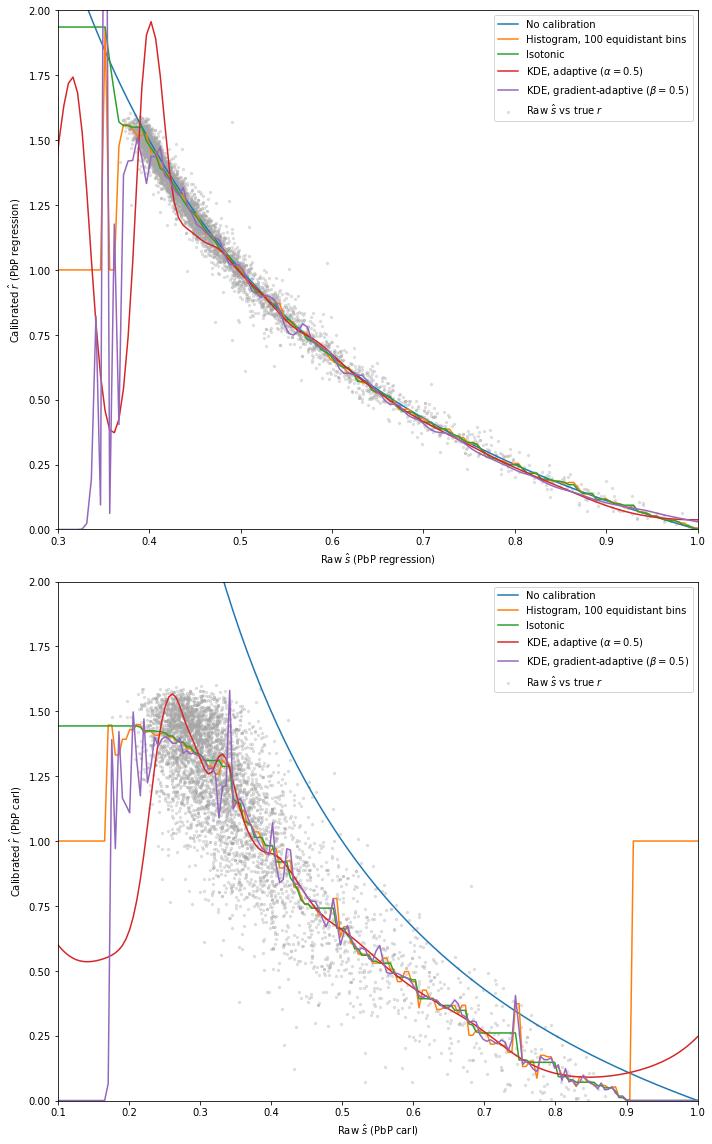

In [38]:
show_indices = [0,3,9,12,16]
plt.figure(figsize=(10.,16.))



plt.subplot(2,1,1)

for s in show_indices:
    plt.plot(s_eval, r_hat_regr_calibrated_eval_list[s], ls='-',
             label=plot_labels[s])

plt.scatter(s_hat_regr_test[::10], r_test[::10], c='0.65', s=5., alpha=0.3, zorder=-10,
           label='Raw $\hat{s}$ vs true $r$')

plt.xlabel('Raw $\hat{s}$ (PbP regression)')
plt.ylabel('Calibrated $\hat{r}$ (PbP regression)')
plt.legend()
plt.xlim(0.3,1.)
plt.ylim(0.,2.)



plt.subplot(2,1,2)

for s in show_indices:
    plt.plot(s_eval, r_hat_carl_calibrated_eval_list[s], ls='-',
             label=plot_labels[s])

plt.scatter(s_hat_carl_test[::10], r_test[::10], c='0.65', s=5., alpha=0.3, zorder=-10,
           label='Raw $\hat{s}$ vs true $r$')

plt.xlabel('Raw $\hat{s}$ (PbP carl)')
plt.ylabel('Calibrated $\hat{r}$ (PbP carl)')
plt.legend()
plt.xlim(0.1,1.)
plt.ylim(0.,2.)



plt.tight_layout()
plt.savefig('../figures/calibration/calibration_curves.pdf')

# Old plots

In [ ]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.scatter(s_hat_calibration[::20], fix_bandwidths_nom[::20], c='C2', s=15., alpha=0.2, label='fixed bw')
plt.scatter(s_hat_calibration[::20], adaptive_bandwidths_nom[::20], c='C1', s=15., alpha=0.2, label='adaptive')
plt.scatter(s_hat_calibration[::20], grad_bandwidths_nom[::20], c='C0', s=15., alpha=0.2, label='grad-adaptive')
plt.legend()
plt.xlabel(r'$s$')
plt.ylabel(r'$h/h_0$')
plt.xlim(0.25,1.02)
plt.ylim(-0.1,25.)

plt.subplot(1,2,2)
plt.scatter(s_hat_calibration[::20], fix_bandwidths_den[::20], c='C2', s=15., alpha=0.2, label='fixed bw')
plt.scatter(s_hat_calibration[::20], adaptive_bandwidths_den[::20], c='C1', s=15., alpha=0.2, label='adaptive')
plt.scatter(s_hat_calibration[::20], grad_bandwidths_den[::20], c='C0', s=15., alpha=0.2, label='grad-adaptive')
plt.legend(loc='upper left')
plt.xlabel(r'$s$')
plt.ylabel(r'$h/h_0$')
plt.xlim(0.25,1.02)
plt.ylim(-0.1,25.)

plt.show()

In [ ]:
print(np.mean(adaptive_bandwidths_den), np.mean(grad_bandwidths_den))

In [ ]:
plt.figure(figsize=(15.,5.))

plt.subplot(1,3,1)
plt.plot(si,p_nom_fix_eval, c='C2', ls=':', label='fixed bw')
plt.plot(si,p_nom_adaptive_eval, c='C1', ls='--', label='adaptive')
plt.plot(si,p_nom_grad_eval, c='C0', ls='-', label='grad-adaptive')
plt.xlabel('s')
plt.ylabel(r'$p_{nom}(s)$')
plt.legend()
plt.xlim(0.2,1.)
plt.ylim(0.,13.)

plt.subplot(1,3,2)
plt.plot(si,p_den_fix_eval, c='C2', ls=':', label='fixed bw')
plt.plot(si,p_den_adaptive_eval, c='C1', ls='--', label='adaptive')
plt.plot(si,p_den_grad_eval, c='C0', ls='-', label='grad-adaptive')
plt.xlabel('s')
plt.ylabel(r'$p_{den}(s)$')
plt.legend()
plt.xlim(0.2,1.)
plt.ylim(0.,8.)

plt.subplot(1,3,3)
plt.plot(si,r_fix_eval, c='C2', ls=':', label='fixed bw')
plt.plot(si,r_adaptive_eval, c='C1', ls='--', label='adaptive')
plt.plot(si,r_grad_eval, c='C0', ls='-', label='grad-adaptive')
plt.xlabel('raw s')
plt.ylabel('r(s)')
plt.legend()
plt.xlim(0.2,1.)
plt.ylim(0.,2.5)

plt.show()

# Effects on r estimation

In [ ]:
plt.figure(figsize=(10,10))

plt.subplot(2,2,1)
plt.plot([0.,2.],[0.,2.],ls='--', c='0.7')
plt.scatter(r_test[::100], r_hat_test[::100], s=15., alpha=0.3)
plt.xlim(0.,2.)
plt.ylim(0.,2.)
plt.xlabel('$r$ (truth)')
plt.ylabel(r'$\hat{r}$ (raw)')

plt.subplot(2,2,2)
plt.plot([0.,2.],[0.,2.],ls='--', c='0.7')
plt.scatter(r_test[::100], r_hat_calibrated_fix_test[::100], s=15., alpha=0.3)
plt.xlabel('$r$ (truth)')
plt.ylabel(r'$\hat{r}$ (calibrated, fixed bw)')
plt.xlim(0.,2.)
plt.ylim(0.,2.)

plt.subplot(2,2,3)
plt.plot([0.,2.],[0.,2.],ls='--', c='0.7')
plt.scatter(r_test[::100], r_hat_calibrated_adaptive_test[::100], s=15., alpha=0.3)
plt.xlabel('$r$ (truth)')
plt.ylabel(r'$\hat{r}$ (calibrated, adaptive bw)')
plt.xlim(0.,2.)
plt.ylim(0.,2.)

plt.subplot(2,2,4)
plt.plot([0.,2.],[0.,2.],ls='--', c='0.7')
plt.scatter(r_test[::100], r_hat_calibrated_grad_test[::100], s=15., alpha=0.3)
plt.xlabel('$r$ (truth)')
plt.ylabel(r'$\hat{r}$ (calibrated, grad-adaptive bw)')
plt.xlim(0.,2.)
plt.ylim(0.,2.)

plt.tight_layout()
plt.show()

# Comparison plot

In [ ]:
plt.figure(figsize=(8,8))

plt.scatter(s_hat_test[::10], r_test[::10], c='0.6', s=5., alpha=0.2)

plt.plot(si,r_fix_eval, c='C2', ls=':', lw=2., label='KDE, fixed bw')
plt.plot(si,r_adaptive_eval, c='C1', ls='--', lw=2., label='KDE, adaptive')
plt.plot(si,r_grad_eval, c='C0', ls='-', lw=2., label='KDE, grad-adaptive')

plt.plot(si,r_histo_eval, c='C3', ls='-.', lw=2., label='histogram')
plt.plot(si,r_iso_eval, c='C4', ls='--', lw=2., label='isotonic')

plt.xlabel('raw s')
plt.ylabel('r(s)')
plt.legend()
plt.xlim(0.2,1.)
plt.ylim(0.,2.)

plt.show()

In [ ]:
print('KDE, fixed bw:', mean_squared_error())